In [3]:
from cooking_bot.data_formats import *
from cooking_bot.encoders import get_clip_text_embedding, get_image_embedding, get_sentence_embedding, CLIP_MODEL, SENTENCE_TRANSORMER
from cooking_bot import REPO_PATH
from glob import glob
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import bertviz
from IPython.display import display
import transformers
from transformers import AutoTokenizer, AutoConfig, AutoModel
import os
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
os.chdir(REPO_PATH)

/home/felix/Documents/web/project


In [4]:
recipes = []

for id, path in enumerate(tqdm(glob("jsons/*.json"), "Filling Index")):
    
    with open(path, "r") as f:

        data = f.read()
    
    recipe = Recipe.model_validate_json(data)
    recipes.append(recipe)

Filling Index: 100%|██████████| 994/994 [00:36<00:00, 27.20it/s] 


In [5]:
many_instructions = [i for i in recipes if len(i.instructions) > 6]

def number_of_images(x : Recipe):
    
    s = 0
    
    for i in x.instructions:
        for img in i.stepImages:
            s += img.embedding is not None
            
    return s




many_instructions.sort(key=number_of_images, reverse=True)

len(many_instructions)

291

In [6]:
recipe : Recipe = many_instructions[6]

number_of_images(recipe), len(recipe.instructions)

(11, 12)

Mushroom Kale Stuffed Shells


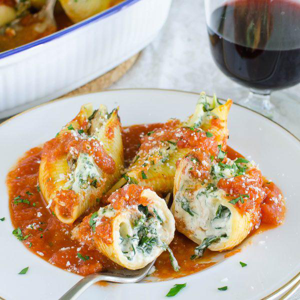

Jumbo Pasta Shells - 1.0 box Jumbo Pasta Shells
Part-Skim Ricotta Cheese - 3⅔ cups Part-Skim Ricotta Cheese
kale - 1.0 bunch Kale
oil - 1.0 Tbsp Olive Oil
mushrooms - 1.0 lb Mushroom
egg - 2.0 Egg
salt - 1.0 tsp Kosher Salt
ground pepper - ½ tsp Ground Black Pepper
garlic powder - ½ tsp Garlic Powder
onion powder - ½ tsp Onion Powder
parsley - ½ cup Fresh Parsley
parmesan cheese - 1½ cups Parmigiano-Reggiano
marinara sauce - 4.0 cups Marinara Sauce


 None 
 Boil the box of Jumbo Pasta Shells according to package directions, but pull them off the heat about 1 minute before al dente. Drain the noodles and rinse with very cold water to stop the cooking process. Drain the noodles and set aside.


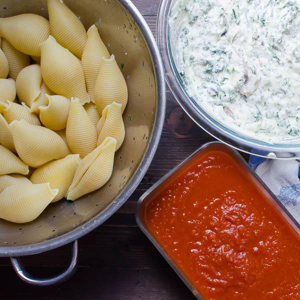



 None 
 In a large saute pan over medium high heat add the Olive Oil and Mushroom. Saute until the mushrooms brown and give up most of their liquid.


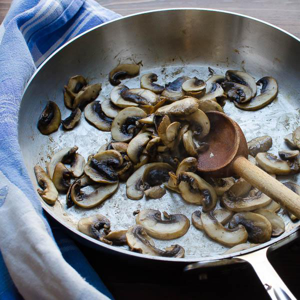



 None 
 Transfer the mushrooms to a bowl. Add the Kale to the pan along with some water, bring the liquid to a boil and cover with a tight fitting lid.


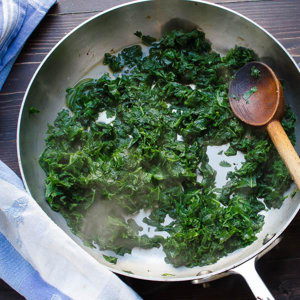



 None 
 Steam the kale for 2 to 3 minutes until wilted, but still bright green. Transfer the kale to a fine mesh sieve and press on the kale with the back of a spoon to squeeze out all of the excess water and set aside.


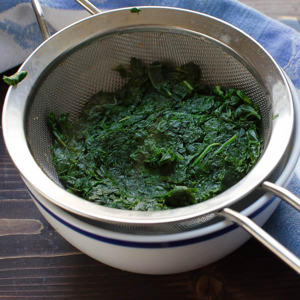



 None 
 In a medium bowl, combine the Part-Skim Ricotta Cheese, Egg, Kosher Salt, Ground Black Pepper, Garlic Powder, Onion Powder, and 1 cup of Parmigiano-Reggiano.


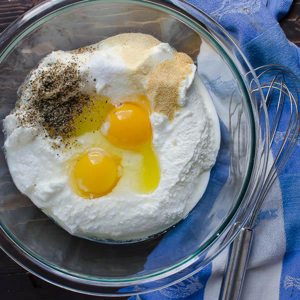



 None 
 With a paper towel, pat dry the mushrooms and make sure the kale is very dry as well.


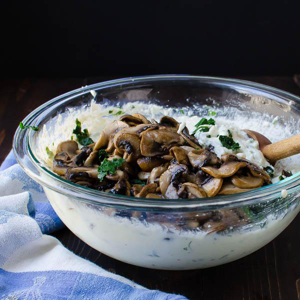



 None 
 Add the mushrooms and kale to the ricotta mixture and stir completely to evenly distribute the vegetables throughout the ricotta.


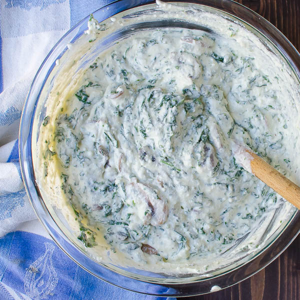



 None 
 Preheat the oven to 350 degrees F (180 degrees C).


 None 
 Spread half a cup of Marinara Sauce in the bottom of the baking dish. Fill the shells with a heaping tablespoon of the ricotta mixture and arrange in the baking dish. Fill in the gaps between the shells with a little extra marinara and sprinkle with the remaining Parmigiano-Reggiano.


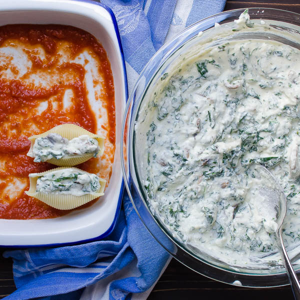



 None 
 Bake for 20 to 25 minutes or until bubbly.


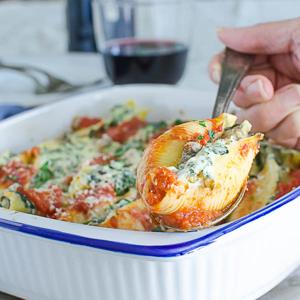



 None 
 Remove from the oven and serve with extra marinara, parmesan cheese, and garnish with Fresh Parsley.


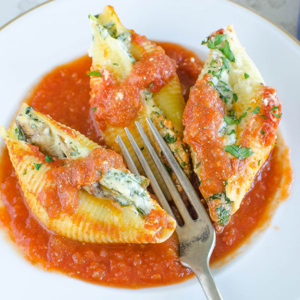



 None 
 Well done! Want to save this recipe to your SideChef cookbook or meal plan? Try “Alexa, send to phone”.


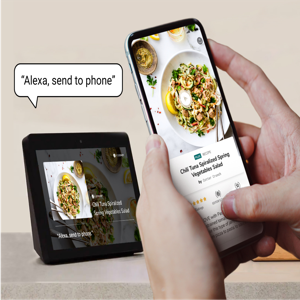

In [85]:
print(recipe.displayName)

display(recipe.images[0].get_image().resize((300, 300),))

for ing in recipe.ingredients:
    print(ing.ingredient, "-", ing.displayText)

for ins in recipe.instructions:
    
    print("\n"*2, ins.stepTitle,"\n", ins.stepText)
    
    
    try:
        display(ins.stepImages[0].get_image().resize((300, 300)))
    except:
        pass
    

    

In [7]:
model_path = "sentence-transformers/all-MiniLM-L6-v2"
sentence_tokenizer = AutoTokenizer.from_pretrained(model_path)
sentence_config = AutoConfig.from_pretrained(model_path,  output_hidden_states=True, output_attentions=True, )  
sentence_model = AutoModel.from_pretrained(model_path, config=sentence_config)

In [102]:
ingredients = [i.ingredient for i in recipe.ingredients]
ingredient_tokens = sentence_tokenizer(ingredients, return_tensors='pt', add_special_tokens=False, max_length = 512, padding=True, truncation = True )
with torch.no_grad():
    ingredient_outputs = sentence_model(**ingredient_tokens)
ingredient_outputs.keys()

hidden_states = ingredient_outputs["hidden_states"]

In [103]:
ingredient_outputs.keys()

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

In [8]:
english = [i.stepText for i in recipe.instructions][:9]

for i in english:
    print(i, "\n")

portugese = """Ferva a caixa de conchas de massa Jumbo de acordo com as instruções da embalagem, mas retire-as do lume cerca de 1 minuto antes de ficarem al dente. Escorra a massa e passe-a por água muito fria para parar o processo de cozedura. Escorra a massa e reserve. 

Numa frigideira grande, em lume médio-alto, adicione o azeite e os cogumelos. Salteie até os cogumelos ficarem castanhos e libertarem a maior parte do seu líquido. 

Transfira os cogumelos para uma tigela. Adicione a couve à panela juntamente com um pouco de água, leve o líquido a ferver e cubra com uma tampa bem apertada. 

Cozinhe a couve a vapor durante 2 a 3 minutos até ficar murcha, mas ainda verde brilhante. Transfira a couve para um passador de rede fina e pressione a couve com as costas de uma colher para espremer todo o excesso de água e reserve. 

Numa tigela média, misture o queijo ricota meio-gordo, o ovo, o sal kosher, a pimenta preta moída, o alho em pó, a cebola em pó e 1 chávena de Parmigiano Reggiano. 

Com uma toalha de papel, seque os cogumelos e certifique-se de que a couve também está bem seca. 

Adicione os cogumelos e a couve à mistura de ricota e mexa completamente para distribuir uniformemente os vegetais pela ricota. 

Pré-aqueça o forno a 350 graus F (180 graus C). 

Espalhe meia chávena de molho Marinara no fundo da assadeira. Encha as conchas com uma colher de sopa cheia da mistura de ricota e disponha-as na assadeira. Preencha os espaços entre as conchas com um pouco mais de marinara e polvilhe com o restante Parmigiano-Reggiano.""".split("\n\n")

german = """Die Jumbo-Nudelschalen nach Packungsanweisung kochen, aber etwa 1 Minute bevor sie al dente sind, vom Herd nehmen. Die Nudeln abgießen und mit sehr kaltem Wasser abspülen, um den Kochvorgang zu stoppen. Die Nudeln abgießen und beiseite stellen. 

In einer großen Sauteuse bei mittlerer Hitze das Olivenöl und die Champignons erhitzen. Anbraten, bis die Pilze braun werden und den größten Teil ihrer Flüssigkeit abgeben. 

Die Pilze in eine Schüssel geben. Den Grünkohl zusammen mit etwas Wasser in die Pfanne geben, die Flüssigkeit zum Kochen bringen und mit einem dicht schließenden Deckel abdecken. 

Den Grünkohl 2 bis 3 Minuten dünsten, bis er welk, aber noch hellgrün ist. Den Grünkohl in ein feinmaschiges Sieb geben und mit einem Löffelrücken auf den Grünkohl drücken, um das überschüssige Wasser herauszudrücken, und beiseite stellen. 

In einer mittelgroßen Schüssel den teilentrahmten Ricotta-Käse, das Ei, das Salz, den gemahlenen schwarzen Pfeffer, das Knoblauchpulver, das Zwiebelpulver und 1 Tasse Parmigiano-Reggiano vermischen. 

Tupfen Sie die Pilze mit einem Papiertuch trocken und stellen Sie sicher, dass auch der Grünkohl sehr trocken ist. 

Pilze und Grünkohl zur Ricotta-Mischung geben und gut umrühren, damit sich das Gemüse gleichmäßig in der Ricotta verteilt. 

Den Ofen auf 350 Grad F (180 Grad C) vorheizen. 

Verteilen Sie eine halbe Tasse Marinara-Soße auf dem Boden der Auflaufform. Die Muscheln mit einem gehäuften Esslöffel der Ricottamischung füllen und in der Auflaufform anordnen. Die Lücken zwischen den Muscheln mit etwas zusätzlicher Marinara auffüllen und mit dem restlichen Parmigiano-Reggiano bestreuen.""".split("\n\n")

polish = """Ugotuj opakowanie makaronu Jumbo Pasta Shells zgodnie z instrukcją na opakowaniu, ale zdejmij je z ognia na około 1 minutę przed al dente. Odcedź makaron i przepłucz bardzo zimną wodą, aby zatrzymać proces gotowania. Odcedź makaron i odłóż na bok. 

Na dużej patelni na średnim ogniu dodać oliwę z oliwek i grzyby. Smażyć, aż grzyby zbrązowieją i oddadzą większość płynu. 

Przełożyć grzyby do miski. Dodaj jarmuż na patelnię wraz z wodą, doprowadź płyn do wrzenia i przykryj szczelną pokrywką. 

Gotuj jarmuż na parze przez 2 do 3 minut, aż zwiędnie, ale nadal będzie jasnozielony. Przenieś jarmuż na sito o drobnych oczkach i naciśnij na jarmuż grzbietem łyżki, aby wycisnąć cały nadmiar wody i odstaw na bok. 

W średniej misce wymieszać częściowo odtłuszczony ser ricotta, jajka, sól koszerną, mielony czarny pieprz, czosnek w proszku, cebulę w proszku i 1 filiżankę Parmigiano-Reggiano. 

Osusz grzyby ręcznikiem papierowym i upewnij się, że jarmuż również jest bardzo suchy. 

Dodaj grzyby i jarmuż do mieszanki ricotty i dokładnie wymieszaj, aby równomiernie rozprowadzić warzywa w ricotcie. 

Rozgrzej piekarnik do 350 stopni F (180 stopni C). 

Rozprowadź pół szklanki sosu marinara na dnie naczynia do zapiekania. Napełnić muszle dużą łyżką stołową mieszanki ricotty i ułożyć w naczyniu do pieczenia. Wypełnić luki między muszlami dodatkową porcją sosu marinara i posypać pozostałym Parmigiano-Reggiano.""".split("\n\n")

len(german), len(portugese), len(polish), len(english)

Boil the box of Jumbo Pasta Shells according to package directions, but pull them off the heat about 1 minute before al dente. Drain the noodles and rinse with very cold water to stop the cooking process. Drain the noodles and set aside. 

In a large saute pan over medium high heat add the Olive Oil and Mushroom. Saute until the mushrooms brown and give up most of their liquid. 

Transfer the mushrooms to a bowl. Add the Kale to the pan along with some water, bring the liquid to a boil and cover with a tight fitting lid. 

Steam the kale for 2 to 3 minutes until wilted, but still bright green. Transfer the kale to a fine mesh sieve and press on the kale with the back of a spoon to squeeze out all of the excess water and set aside. 

In a medium bowl, combine the Part-Skim Ricotta Cheese, Egg, Kosher Salt, Ground Black Pepper, Garlic Powder, Onion Powder, and 1 cup of Parmigiano-Reggiano. 

With a paper towel, pat dry the mushrooms and make sure the kale is very dry as well. 

Add the m

(9, 9, 9, 9)

In [38]:
langs = {
    "english": english,
    "german": german,
    "portugese": portugese,
    "polish": polish,
}

def gethidden_states(list_of_text):
    ingredient_tokens = sentence_tokenizer(list_of_text, return_tensors='pt', add_special_tokens=False, max_length = 512, padding=True, truncation = True )
    with torch.no_grad():
        ingredient_outputs = sentence_model(**ingredient_tokens)
    return ingredient_outputs["hidden_states"]
    
hidden_states_per_lang = {i: gethidden_states(v) for i,v in langs.items()}

/tmp/ipykernel_15986/1873666898.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


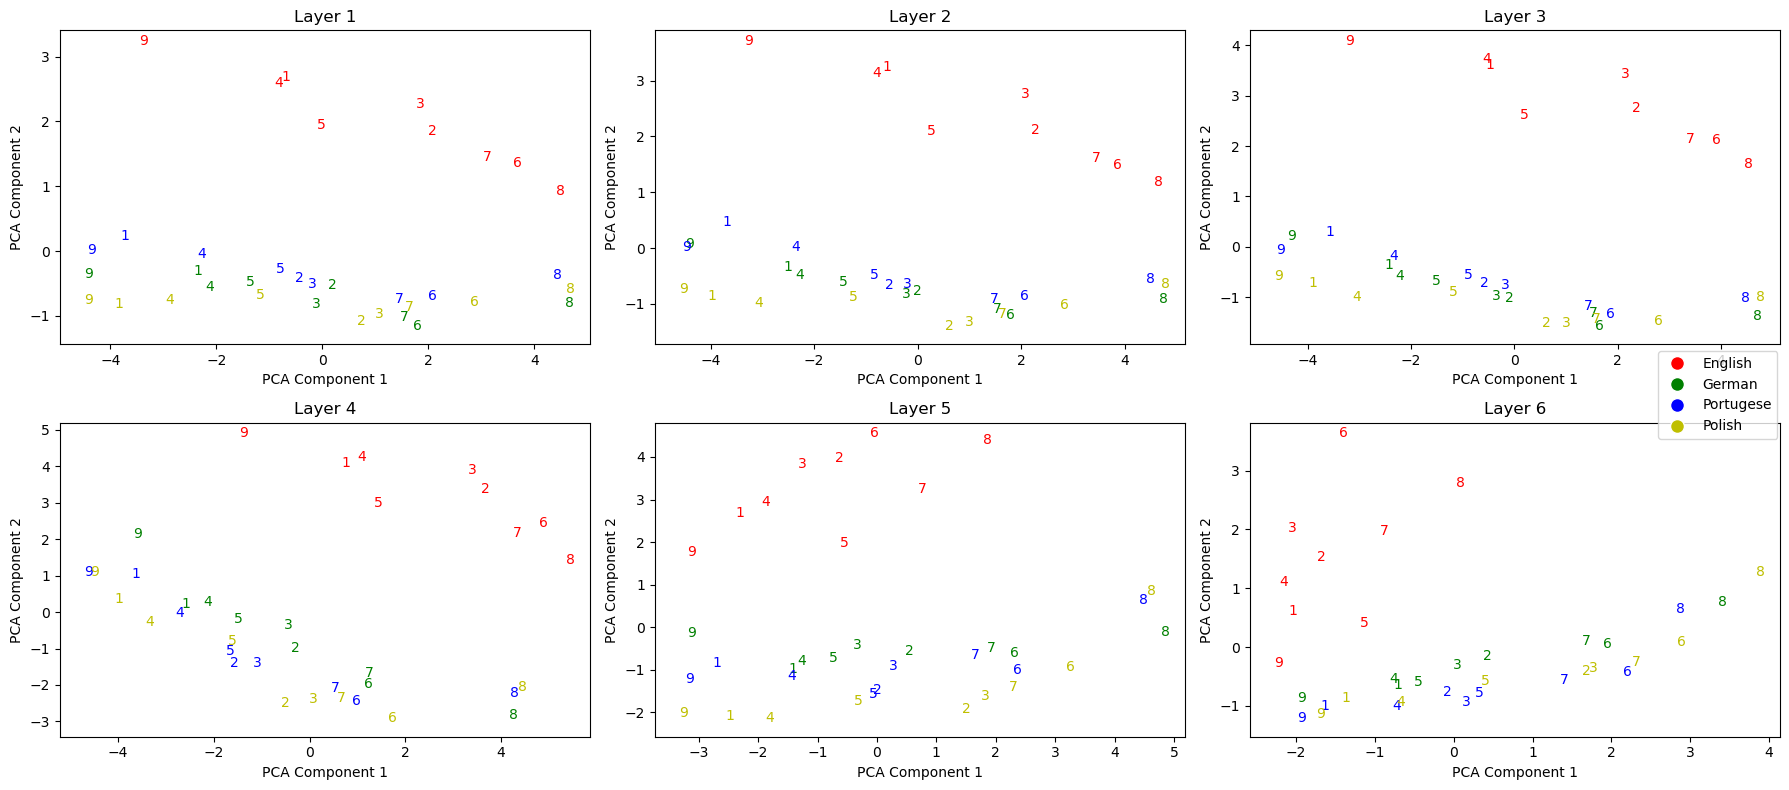

In [40]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# Assuming hidden_states_per_lang is already defined and contains the hidden states
lan_list = list(langs.keys())
step_list = list(range(1, 10))  # Example step numbers

# Prepare data for plotting
digits = np.tile(np.arange(1, 10), len(lan_list)).astype(str)  # Step numbers as strings
lans = np.repeat(lan_list, len(step_list))  # Repeated language list

# Colors and markers
colors = {'english': 'r', 'german': 'g', 'portugese': 'b', 'polish': 'y'}
markers = ['o', '^', 's', 'p', '*', '+', 'x', 'D', 'h']  # One marker for each step

# Plotting setup
rows, cols = 2, 3
fig, ax_full = plt.subplots(rows, cols, figsize=(cols * 6, rows * 4))
layer = 1  # Starting layer index

for r in range(rows):
    for c in range(cols):
        ax = ax_full[r, c]
        current_hidden_state = np.concatenate([
            hidden_states_per_lang[lang][layer].mean(1).detach().numpy() for lang in lan_list
        ])
        twodim = PCA(n_components=2).fit_transform(current_hidden_state)
        
        # Scatter plot for each language and step
        for idx, (lang, digit) in enumerate(zip(lans, digits)):
            color = colors[lang.lower()]
            marker = markers[int(digit) - 1]
            # ax.scatter([],[])
            ax.scatter(twodim[idx, 0], twodim[idx, 1], color=color, label=f'{lang} Step {digit}', alpha = 0)
            ax.text(twodim[idx, 0], twodim[idx, 1], digit, color=color)

        # Set titles and labels
        ax.set_title(f"Layer {layer}")
        ax.set_xlabel('PCA Component 1')
        ax.set_ylabel('PCA Component 2')
        
        # Update layer index for next plot
        layer += 1

legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=language.title(),
                              markerfacecolor=color, markersize=10)
                   for language, color in colors.items()]


# Create an additional axis for the legend
legend_ax = fig.add_axes([0.92, 0.1, 0.02, 0.8])  # Adjust these coordinates to fit your layout
legend_ax.axis('off')  # Hide the legend axis
legend_ax.legend(handles=legend_elements, loc='center left')

plt.tight_layout()
plt.savefig('imgs/hidde_states.png', bbox_inches='tight')

plt.show()


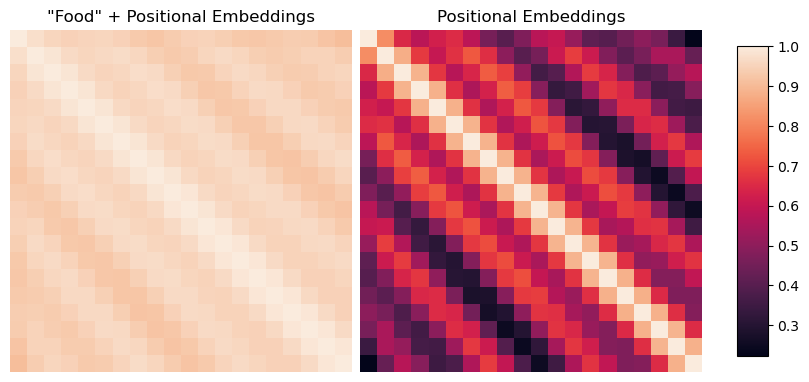

In [166]:
inputs = sentence_tokenizer(["food"] * 21, add_special_tokens = False, return_tensors='pt')["input_ids"]
inputs = inputs.flatten().unsqueeze(0)

embeddings = torch.nn.functional.normalize(sentence_model.embeddings(inputs)[0])[1:]
sim = (embeddings @ embeddings.T).detach().numpy()

pos_embeddings = torch.nn.functional.normalize(sentence_model.embeddings.position_embeddings(torch.arange(21).unsqueeze(0))[0])[1:]
pos_sim = (pos_embeddings @ pos_embeddings.T).detach().numpy()


vmin = min(sim.min(), pos_sim.min())
vmax = 1  # Assuming similarity scores are normalized to 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), layout='constrained')

sns.heatmap(sim, ax=ax1, cbar=False, square=True, vmin=vmin, vmax=vmax,)
ax1.set(title='"Food" + Positional Embeddings')
ax1.set_xticks([])
ax1.set_yticks([])

sns.heatmap(pos_sim, ax=ax2, square=True, vmin=vmin, vmax=vmax, cbar=False)
ax2.set(title="Positional Embeddings")
ax2.set_xticks([])
ax2.set_yticks([])

# Add a color bar to the right of the plots
fig.colorbar(ax2.collections[0], ax=[ax1, ax2], location="right", aspect=10, shrink = 0.8)
plt.savefig("imgs/pos.png", )
plt.show()

In [46]:
sentence = english[-4]
sentence_tokens = sentence_tokenizer(sentence, return_tensors='pt', add_special_tokens=False, max_length = 512, padding=True, truncation = True )
with torch.no_grad():
    sentence_outputs = sentence_model(**sentence_tokens)



odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states', 'attentions'])

In [47]:
len(sentence_outputs["attentions"])

6